# ENSO_seasonality: Seasonal Variability of SST Anomalies in the Central Equatorial Pacific  

Computes the ratio of boreal winter (November–January, NDJ) to spring (March–May, MAM) standard deviation of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W). This metric evaluates the seasonality of ENSO variability, characterised by maximum variability in winter and minimum variability in spring in the observations.  

## Datasets Used for Seasonality Comparison  

The following reference datasets are used to evaluate the seasonal variability of ENSO-related SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, designed for analysing tropical climate variability, including surface fluxes and SST anomalies.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A historical reanalysis product providing long-term atmospheric data using surface pressure observations.  
- **ERA-Interim (1979–2018)**: A high-resolution reanalysis dataset offering consistent atmospheric and surface variable estimates.  
- **ERSSTv5 (1854–2018)**: A globally gridded dataset optimised for climate monitoring, including ENSO-related SST anomaly studies.  
- **HadISST (1870–2018)**: A historical dataset combining SST and sea ice observations with reconstructions.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis product delivering improved atmospheric and surface data globally.  


## Dask Cluster 

Start a cluster with multiple cores 

In [ ]:
from dask.distributed import Client, progress
client = Client()
client

## Datasets

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [6]:
def sst_boreal(cube, season): #season->'NDJ','MAM'
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season) # get NDJ
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube


In [7]:
def sst_std(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube, operator='mean')
    cube = climate_statistics(cube, operator="std_dev", period="monthly") #monthly to plot months
    return cube
    
def sst_std_3(cube):
    nino34_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = regrid(cube, target_grid="0.5x0.5", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube, 'mean')
    cube = climate_statistics(cube, operator="std_dev", period="monthly") #monthly
    return cube

In [8]:
model_datasets_prep = {name: sst_boreal(dataset, 'NDJ') for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: sst_boreal(dataset,'NDJ') for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: sst_boreal(dataset, 'MAM') for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: sst_boreal(dataset,'MAM') for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. 

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [9]:
model_ = {'borealwinter':model_datasets_prep["ACCESS-ESM1-5"], 'borealspring':model_datasets_prep2["ACCESS-ESM1-5"]}

obs_ = {'borealwinter':obs_datasets_prep["HadISST"], 'borealspring':obs_datasets_prep2["HadISST"]}

mod_seas = model_['borealwinter'].data.item()/model_['borealspring'].data.item()
obs_seas = obs_['borealwinter'].data.item()/obs_['borealspring'].data.item()

# abs((mod_seas-obs_seas)/obs_seas)*100, mod_seas, obs_seas

Text(0.75, 0.8, '* observation')

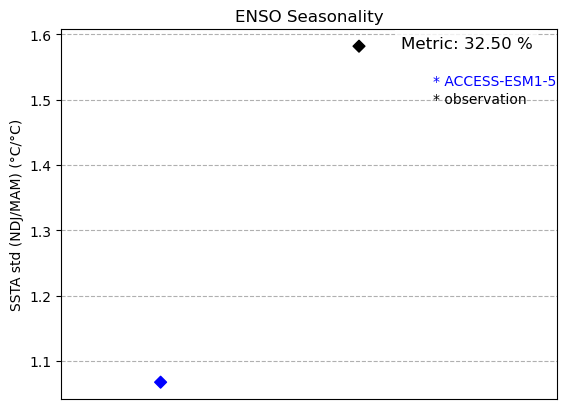

In [10]:
ssta_std = [mod_seas, obs_seas]
plt.scatter(range(len(ssta_std)), ssta_std, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA std (NDJ/MAM) (°C/°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO Seasonality')

metricval = abs((mod_seas-obs_seas)/obs_seas)*100

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
# plt.legend(loc='lower right')

**Figure 1**: Ratio of winter to spring standard deviation of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the seasonal timing of SSTA. The model generally exhibits weaker variability compared to observations, indicating that ENSO events tend to occur too frequently during spring in the model. In this case, the seasonal timing is slightly overrepresented. Black markers denote the reference data, while blue markers denote the model output. 

The derived metric is the absolute relative difference, calculated as:

\[
\text{Absolute Relative Difference} = \left| \frac{\text{Model} - \text{Reference}}{\text{Reference}} \right| \times 100
\]


## Diagnostic Level 2

The second level shows the mean annual structure of the ENSO amplitude: the 12 months standard deviation of the anomalies.

In [11]:
model_data_prep = {name: sst_std(dataset) for name, dataset in model_datasets.items()}
obs_data_prep = {name: sst_std(dataset) for name, dataset in obs_datasets.items()}

data_prep_2 = [model_data_prep["ACCESS-ESM1-5"], obs_data_prep["HadISST"]]

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


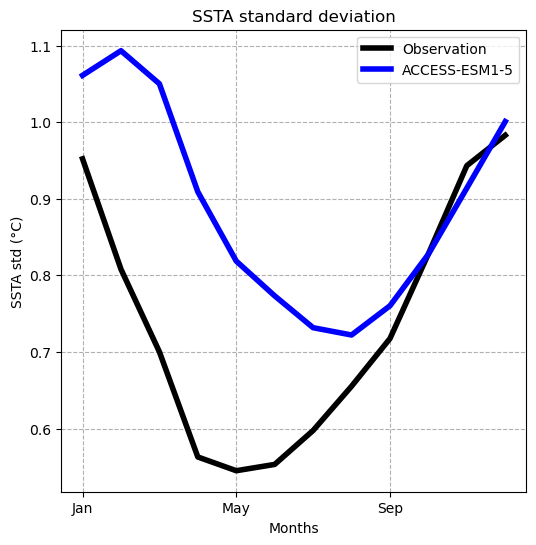

In [12]:

# Create the plot
plt.figure(figsize=(6, 6))

# Plot observation data in black
qplt.plot(data_prep_2[1], color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(data_prep_2[0], color='blue', label='ACCESS-ESM1-5', linewidth=4)

# Define x-axis labels
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = ['Jan', 'May', 'Sep']
plt.xticks(range(1,13,4),labels=months)
# Set the x and y axis labels
plt.xlabel('Months')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.grid(linestyle='--'); plt.legend()


**Figure 2**: Mean annual structure of the standard deviation of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the seasonal variability. The model typically shows too strong variability in winter and in spring. The black curve represents the reference data, while the blue curve corresponds to the model output.

## Diagnostic Level 3

The third level shows the spatio-mean annual structure of the ENSO amplitude: the Hovmöller of the standard deviation of anomalies in the equatorial Pacific.

In [14]:
model_data_prep3 = {name: sst_std_3(dataset) for name, dataset in model_datasets.items()}
obs_data_prep3 = {name: sst_std_3(dataset) for name, dataset in obs_datasets.items()}

data_prep_3 = {**model_data_prep3, "HadISST":obs_data_prep3["HadISST"]}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype

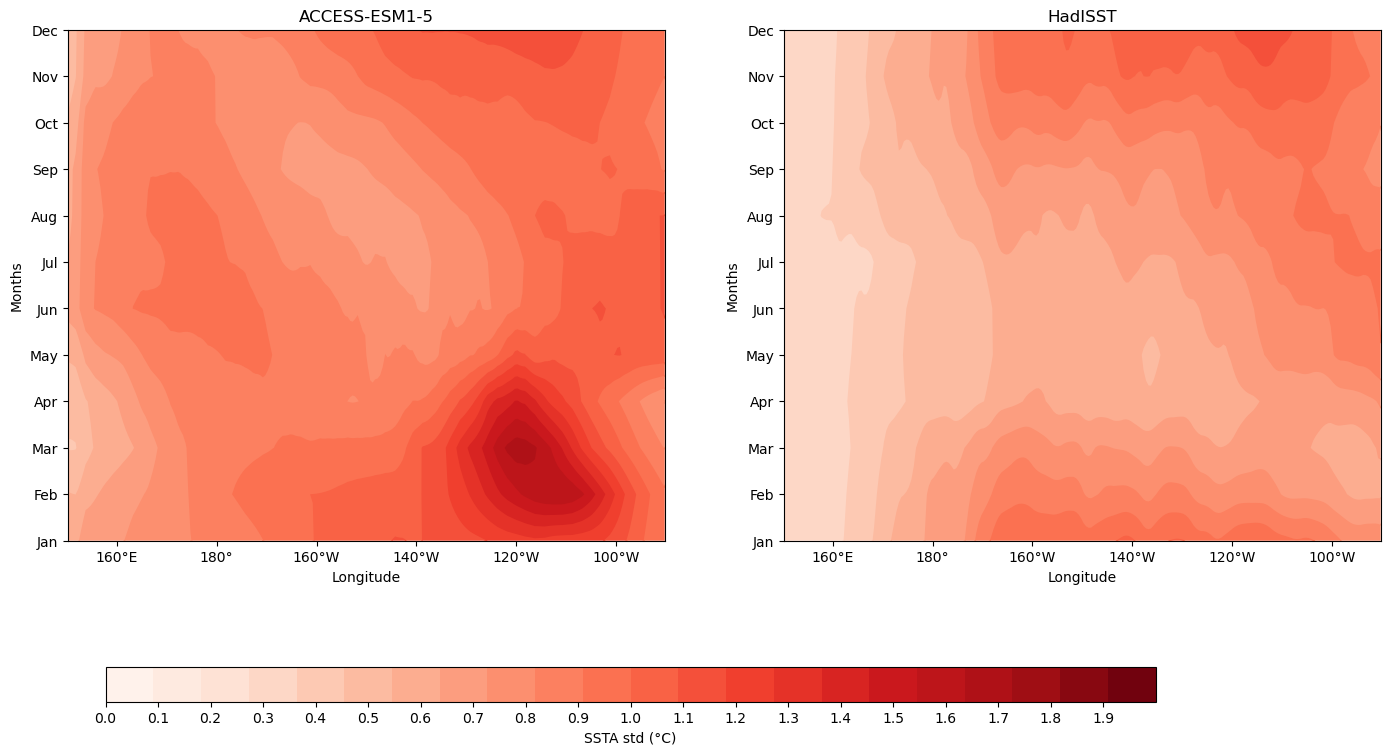

In [46]:
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure
fig = plt.figure(figsize=(15, 7))
i = 121  # Subplot indexing

# Function to format longitude labels
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

# Define month labels for the y-axis
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot data for each label and cube in the dictionary
for label, cube in data_prep_3.items():
    ax = plt.subplot(i)  # Add projection for geographic plots
    c1 = iplt.contourf(cube, cmap='Reds', levels=np.linspace(0., 2.0, 23))  # Set levels to include <0 and >2
    ax.set_yticks(range(1, 13))
    ax.set_yticklabels(months)
    ax.set_title(label)
    ax.set_ylabel("Months")
    ax.set_xlabel("Longitude")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
    i += 1

fig.subplots_adjust(bottom=0.15, right=1.0)  # Adjust bottom margin to fit colorbar
# Add a horizontal colorbar with open ends to include values outside the range
cax = plt.axes([0.15, -0.08, 0.7, 0.05])  # Position for colorbar
cbar = fig.colorbar(c1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0, 2.0, 0.1))
cbar.set_label('SSTA std (°C)')

plt.show()

Figure 3: Spatio-mean annual structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N). The figure typically shows too weak variability off the coast of South America and too strong variability in the central Pacific during spring. Additionally, there is too weak variability in the central-eastern Pacific during winter and excessive variability west of the dateline year-round. In this case, while the seasonal timing of ENSO is roughly captured, the variability in the central Pacific is overly strong during autumn. The left map displays the reference data, while the right map shows the model output.

### Dive down level 4:
The fourth level shows the zonal structure of the ENSO amplitude during winter and spring: the standard deviation of the anomalies along the equator in the Pacific.

In [47]:
## from level 3 -extract season, full climate statictics
def sst_std_3(cube):
    nino34_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube, 'mean')
    # cube = climate_statistics(cube, operator="std_dev", period="monthly") # monthly remove from 3
    return cube

model_data_prep3 = {name: sst_std_3(dataset) for name, dataset in model_datasets.items()}
obs_data_prep3 = {name: sst_std_3(dataset) for name, dataset in obs_datasets.items()}
data_prep_3 = {**model_data_prep3, "HadISST":obs_data_prep3["HadISST"]}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. 

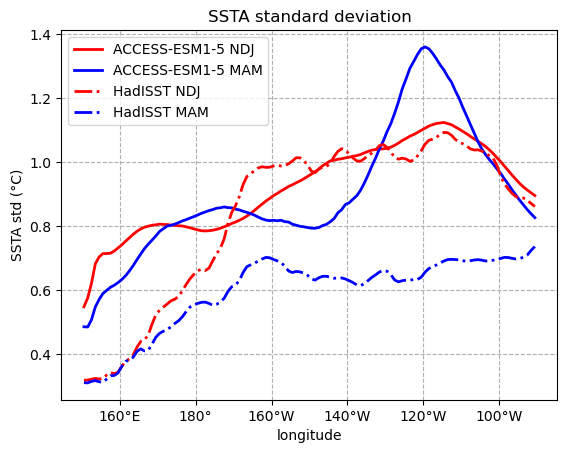

In [54]:
        
lines = {'ACCESS-ESM1-5': 'solid', 'HadISST': 'dashdot'}
for label, cube in data_prep_3.items():
    for seas, col in {'NDJ':'red','MAM':'blue'}.items():
        cube_plot = extract_season(cube, seas) # get NDJ #{ NDJ, MAM, red, blue
        cube_plot = climate_statistics(cube_plot, operator="std_dev", period="full")
        qplt.plot(cube_plot, color=col, label=label + " " + seas,linestyle=lines[label], linewidth=2)
        
##
plt.xlabel('longitude')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.legend()
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

**Figure 4**: Zonal structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N) during winter (red curves) and spring (blue curves). In winter, the model typically shows weaker variability in the central-eastern Pacific and stronger variability west of the dateline. In spring, the model shows weaker variability off the coast of South America and stronger variability elsewhere. Although the zonal structure of the ENSO amplitude is captured reasonably well, the variability off South America is too weak in both seasons. The dashed curves represent the reference data, while the solid curves represent the model output.